In [1]:
import numpy as np
from classy import Class
from Francisco import trapezoid, right_rectangle, factors, xy_values
import scipy.interpolate as sp
import matplotlib.pyplot as plt
import os


import matplotlib.pyplot as plt
import numpy as np
import numba as nb
import ODEsolver as solve
from run import g, temp, gs, gss
from run import with_spline_ODE, steps_taken
from Emma import sterile_production

In [2]:
M_sol = 1.989e30 # solar mass in kg
Mpc = 3.086e22 # Mpc in m
c=np.logspace(-11.3,-5, 40)
kvec = np.logspace(-4,np.log10(100),100)
measured_omegacdm=.1188
Sig_8 = 0.811
A_s = 2.1e-9

In [3]:
commonsettings = {
          'N_ncdm':1,
          'use_ncdm_psd_files': 1,
          'm_ncdm': 7100,
          'T_ncdm':0.7,
          'output':'mPk',
          'P_k_max_1/Mpc':100.0,
          ## The next line should be uncommented fgor higher precision (but significantly slower running)
          'ncdm_fluid_approximation':3,
          ## You may uncomment this line to get more info on the ncdm sector from Class:
          'background_verbose':1,
          'Maximum q':100
         } 

In [4]:
def ideal_sigma8 (spec_file, omega_h_h):
    
    NH = Class()
        #use method .set() to 
    NH.set(commonsettings)
    othersettings = { 'ncdm_psd_filenames': spec_file,
                      'omega_cdm': measured_omegacdm - omega_h_h, 
                      'omega_ncdm': omega_h_h, 
                      'A_s': 2.1e-9,
                    }

    #use method .compute() to get data for my specific 'Spec-' file
    NH.set(othersettings)
    NH.compute()

    Sigma8_value = NH.sigma8()
    print("",Sigma8_value,"")
    
    ideal_value = ((Sig_8)/(Sigma8_value))**2*(A_s)
    
    NH.struct_cleanup()
    
    return ideal_value

In [5]:
def make_Pk(spec_file,omega_h_h):
    
    othersettings = { 'ncdm_psd_filenames': spec_file,
                      'omega_cdm': measured_omegacdm - omega_h_h, 
                      'omega_ncdm': omega_h_h, 
                      'A_s': ideal_sigma8(spec_file, omega_h_h),
                    }
    
    for key, value in othersettings.items():
        print(key, ' : ', value)
    for key, value in commonsettings.items():
        print(key, ' : ', value)
    
    # array of k values in 1/Mpc


    NH = Class()
    NH.set(commonsettings)
    NH.set(othersettings)
    NH.compute()
    
    new_sig8 = NH.sigma8()
    pkNH = [] 
    
        #MPk- Matter Power Spectrum
    for k in kvec:
        pkNH.append(NH.pk(k,0.))
    h = NH.h()
    NH.struct_cleanup()
    

    np.save(spec_file+ '-Pknew',np.array(pkNH))
    np.save(spec_file+'-knew',kvec/h)
    
    return new_sig8

In [6]:
def trap(f,x):
    integral = 0
    for i in range(1,len(f)):
        integral += 0.5 * (f[i] + f[i-1]) * (x[i] - x[i-1])
    return integral

def R(M):
    c = 2.5
    G = 6.67e-11 # m^3 / kg / s^2
    H100 = 100 * (1000/Mpc) # km/s/Mpc -> 1/s
    omegah2 = 0.1188

    rhobar = omegah2 * 3 * H100**2 / (8 * np.pi * G) / M_sol * Mpc**3 # kg / m^3 -> M_sol / Mpc^3
    return (3 * M / (4 * np.pi * rhobar * c**3))**(1/3) # Mpc

def W(k,R):
        if np.isscalar(k):
            if k * R > 1:
                return 0
            else:
                return 1
        else:
            result = np.zeros(len(k))
            for i in range(len(k)):
                if k[i] * R < 1 and k[i+1] * R > 1:
                    result[i] = (1 - k[i] * R)/(k[i+1]*R - k[i]*R)
                elif k[i] * R < 1:
                    result[i] = 1
            return result
        
def S(M):
        Rv = R(M)
        
        integrand = k_vals**2 * Pk_vals * W(k_vals, Rv)**2 / (2 * ( np.pi**2))
        return trap(integrand,k_vals)


def dNdlnM(M):
    Rv = R(M)
    return 1 / 44.5 / (6 * np.pi**2) * (M0 / M) / Rv**3 / np.sqrt(2 * np.pi * ( S(M) - S(M0))) * P_spline(1/Rv)


def Bella_2(file_name, k): ##.npz as first input and step size as the second
    
    a,b,c,d,e = xy_values(file_name, k)
    
    dat = np.load('Neutrino Data/' + file_name)

    omega_h_h = dat['omega_h2']
    a,b,c,d,e = xy_values(file_name, k)
    np.savetxt("Spec", np.column_stack((a,b)))
    spec_file  = 'Spec'
    
    make_Pk(spec_file, omega_h_h)
    
    global k_vals
    k_vals = np.load('Spec-knew.npy')
    global Pk_vals
    Pk_vals = np.load('Spec-Pknew.npy')
    

    global M0
    M0 = 3.2e12 # M_sol / h
    global P_spline
    P_spline  = sp.CubicSpline(k_vals,Pk_vals)


    global ln_vals
    lnM_vals = np.linspace(np.log(1e8),np.log(M0))
    
    sv = np.zeros(len(lnM_vals)-1)
    for i in range(len(sv)):
        sv[i] = S(np.exp(lnM_vals[i]))- S(np.exp(lnM_vals[-1]))
    
    integrand = np.zeros(len(lnM_vals)-1)

    for i in range(len(integrand)):
        integrand[i] = dNdlnM(np.exp(lnM_vals[i]))
        
    integral = trap(integrand,lnM_vals[:-1])
                
    return integral, integrand, sv, lnM_vals


0.00244599399625019

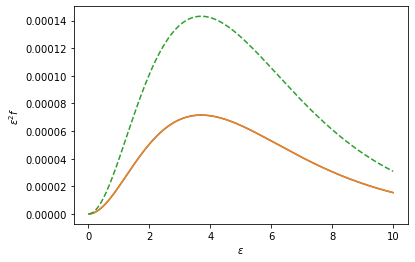

In [7]:
sterile_production(1000, 'electron', 0.0071, 10**(-10), 1e-20, make_plot=True, folder_name="Neutrino Data")

In [8]:
def file_name():
    file_str = []
    length = os.listdir('Neutrino Data/')
    for i in range(len(length)):
        curr = length[i]
        file_str.append(curr)
    return file_str


file_names = file_name()
file_name = str(file_names[2])
print(file_name)
dat = np.load('Neutrino Data/' + file_name)

electronx1e-20x1e-10.npz


In [9]:
w,x,y,z = Bella_2(file_name, 4)

 0.8194849610935495 
ncdm_psd_filenames  :  Spec
omega_cdm  :  0.11635400600374982
omega_ncdm  :  0.00244599399625019
A_s  :  2.0567382611361667e-09
N_ncdm  :  1
use_ncdm_psd_files  :  1
m_ncdm  :  7100
T_ncdm  :  0.7
output  :  mPk
P_k_max_1/Mpc  :  100.0
ncdm_fluid_approximation  :  3
background_verbose  :  1
Maximum q  :  100


In [10]:
print(w)

477.28384742679276


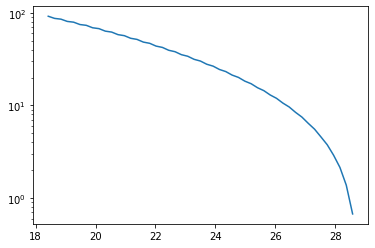

[91.91375913 87.12200498 85.48745749 80.81715015 79.31571827 74.77524302
 73.3254074  68.98938666 67.53114784 63.45295268 61.99171073 58.16435421
 56.70617412 53.11909025 51.66926963 48.31602977 46.88058664 43.75266577
 42.33708711 39.42715316 38.03724198 35.33851321 33.97928932 31.48222553
 30.15837019 27.85551189 26.57128578 24.45325585 23.21218538 21.26983875
 20.07543387 18.30034688 17.15514536 15.53736619 14.44375576 12.9746244
 11.93442239 10.60464902  9.61914952  8.41967917  7.49013071  6.41261201
  5.5394466   4.57498667  3.75856256  2.89910309  2.13932797  1.37682723
  0.67326106]
[4.76438075e+02 3.88136582e+02 3.10916745e+02 2.53584827e+02
 2.02952667e+02 1.65529553e+02 1.32411088e+02 1.08084350e+02
 8.65367750e+01 7.06711665e+01 5.65910820e+01 4.61955939e+01
 3.70015231e+01 3.02170238e+01 2.42115710e+01 1.97658489e+01
 1.58386140e+01 1.29305416e+01 1.03656361e+01 8.46242269e+00
 6.78392610e+00 5.53617895e+00 4.44020576e+00 3.62523334e+00
 2.90928321e+00 2.37528034e+00 1.9074

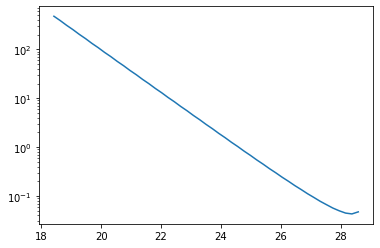

477.28384742679276


In [11]:
plt.figure()
plt.semilogy(z[:-1],y)
plt.show()
print(y)


for i in range(len(x)):
    x[i] = dNdlnM(np.exp(z[i]))
    
    
print(x)


print(w)
plt.figure()
plt.semilogy(z[:-1],x)
plt.show()    



print(w) 

In [12]:
Pure_lambdaCDM = np.load('Neutrino Data/1x0.00049x3e-09-data.npz')
Pure_lambdaCDM.files

#alpha, beta, gamma, delta = Bella_2(Pure_lambdaCDM,4)

['eps', 'f', 'eps_full', 'f_full', 'omega_s', 'a', 'T', 'Lep']